Data Initialization

In [13]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Applying data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation and test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the datasets with new transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Re-split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Baseline CNN Model

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

        # Pooling and dropout layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# CNN
baseline_model = BaselineCNN().to(device)


In [24]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 20
batch_size = 64

# Use of Adam optimizer
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# DataLoaders (reusing train_loader and val_loader)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training the baseline CNN model
train_losses, val_losses, train_accuracies, val_accuracies = train(
    baseline_model, train_loader, val_loader, optimizer, criterion, num_epochs
)

# Testing the baseline CNN model
test(baseline_model, test_loader)


Epoch [1/20], Train Loss: 1.6998,  Train Accuracy: 0.3737, Val Loss: 1.4907, Val Accuracy: 0.4615
Epoch [2/20], Train Loss: 1.3677,  Train Accuracy: 0.5109, Val Loss: 1.2603, Val Accuracy: 0.5521
Epoch [3/20], Train Loss: 1.1785,  Train Accuracy: 0.5789, Val Loss: 1.0619, Val Accuracy: 0.6267
Epoch [4/20], Train Loss: 1.0552,  Train Accuracy: 0.6272, Val Loss: 0.9811, Val Accuracy: 0.6532
Epoch [5/20], Train Loss: 0.9771,  Train Accuracy: 0.6569, Val Loss: 0.9308, Val Accuracy: 0.6710
Epoch [6/20], Train Loss: 0.9267,  Train Accuracy: 0.6726, Val Loss: 0.9381, Val Accuracy: 0.6736
Epoch [7/20], Train Loss: 0.8811,  Train Accuracy: 0.6892, Val Loss: 0.8637, Val Accuracy: 0.6976
Epoch [8/20], Train Loss: 0.8404,  Train Accuracy: 0.7063, Val Loss: 0.8235, Val Accuracy: 0.7151
Epoch [9/20], Train Loss: 0.8194,  Train Accuracy: 0.7118, Val Loss: 0.8499, Val Accuracy: 0.7084
Epoch [10/20], Train Loss: 0.7894,  Train Accuracy: 0.7244, Val Loss: 0.7891, Val Accuracy: 0.7280
Epoch [11/20], Trai

ResNet from scratch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.resnet import BasicBlock

# ResNet-18 architecture from scratch
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Defining the layers as per ResNet-18
        self.layer1 = self._make_layer(BasicBlock, 64, 2)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1)
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = ResNet18(num_classes=10)
print(model)


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [19]:
import numpy as np
from sklearn.metrics import accuracy_score

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience=3):
    best_val_loss = np.inf
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation Phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = train_correct / len(train_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


Hyper-Parameter Tuning with Bayesian Optimization

In [4]:
!pip install scikit-optimize

In [20]:
import optuna
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Defining search space for hyperparameters
space = [
    Real(1e-4, 1e-2, name='learning_rate'),
    Categorical(['SGD', 'Adam'], name='optimizer_type'),
    Real(0.0, 0.5, name='dropout'),
    Integer(10, 30, name='epochs'),
    Integer(32, 128, name='batch_size')
]

@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    optimizer_type = params['optimizer_type']
    dropout = params['dropout']
    epochs = params['epochs']
    batch_size = int(params['batch_size'])  # To ensure batch_size is an integer

    model = ResNet18().to(device)
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_losses, val_losses, train_accuracies, train_losses = train(model, train_loader, val_loader, optimizer, criterion, epochs)

    return min(val_losses)

# Bayesian Optimization
result = gp_minimize(objective, space, n_calls=10, random_state=0)
print("Best hyperparameters found:", result.x)

Epoch [1/27], Train Loss: 2.0047,  Train Accuracy: 0.2741, Val Loss: 1.7225, Val Accuracy: 0.3520
Epoch [2/27], Train Loss: 1.6188,  Train Accuracy: 0.4087, Val Loss: 1.5350, Val Accuracy: 0.4433
Epoch [3/27], Train Loss: 1.3905,  Train Accuracy: 0.4956, Val Loss: 1.4056, Val Accuracy: 0.5040
Epoch [4/27], Train Loss: 1.2226,  Train Accuracy: 0.5646, Val Loss: 1.2518, Val Accuracy: 0.5577
Epoch [5/27], Train Loss: 1.1010,  Train Accuracy: 0.6103, Val Loss: 1.0987, Val Accuracy: 0.6088
Epoch [6/27], Train Loss: 1.0109,  Train Accuracy: 0.6443, Val Loss: 1.0611, Val Accuracy: 0.6298
Epoch [7/27], Train Loss: 0.9349,  Train Accuracy: 0.6720, Val Loss: 0.9838, Val Accuracy: 0.6530
Epoch [8/27], Train Loss: 0.8823,  Train Accuracy: 0.6926, Val Loss: 0.8781, Val Accuracy: 0.6941
Epoch [9/27], Train Loss: 0.8369,  Train Accuracy: 0.7097, Val Loss: 0.8431, Val Accuracy: 0.7097
Epoch [10/27], Train Loss: 0.7926,  Train Accuracy: 0.7252, Val Loss: 0.8360, Val Accuracy: 0.7076
Epoch [11/27], Trai

Epoch [1/27], Train Loss: 1.9591,  Train Accuracy: 0.2935, Val Loss: 1.8419, Val Accuracy: 0.3827
Epoch [2/27], Train Loss: 1.6104,  Train Accuracy: 0.4139, Val Loss: 1.4980, Val Accuracy: 0.4536
Epoch [3/27], Train Loss: 1.4253,  Train Accuracy: 0.4845, Val Loss: 1.3148, Val Accuracy: 0.5219
Epoch [4/27], Train Loss: 1.2539,  Train Accuracy: 0.5506, Val Loss: 1.2415, Val Accuracy: 0.5548
Epoch [5/27], Train Loss: 1.1230,  Train Accuracy: 0.5996, Val Loss: 1.0976, Val Accuracy: 0.6141
Epoch [6/27], Train Loss: 1.0215,  Train Accuracy: 0.6392, Val Loss: 1.0845, Val Accuracy: 0.6172
Epoch [7/27], Train Loss: 0.9569,  Train Accuracy: 0.6619, Val Loss: 0.9478, Val Accuracy: 0.6714
Epoch [8/27], Train Loss: 0.8898,  Train Accuracy: 0.6878, Val Loss: 0.9165, Val Accuracy: 0.6844
Epoch [9/27], Train Loss: 0.8467,  Train Accuracy: 0.7060, Val Loss: 0.8705, Val Accuracy: 0.6925
Epoch [10/27], Train Loss: 0.7999,  Train Accuracy: 0.7233, Val Loss: 0.8152, Val Accuracy: 0.7196
Epoch [11/27], Trai

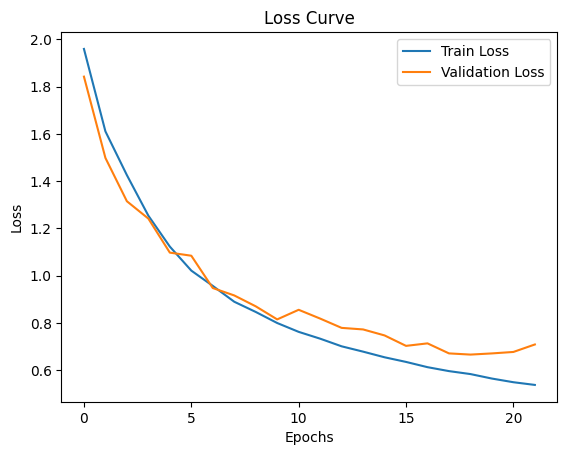

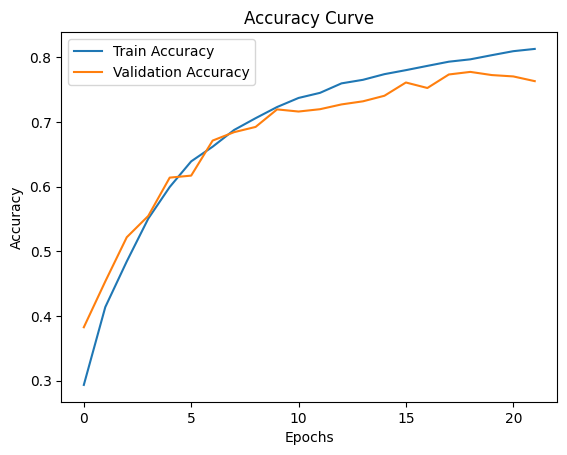

In [21]:
learning_rate = result.x[0]
optimizer_type = result.x[1]
dropout = result.x[2]
epochs = result.x[3]
batch_size = int(result.x[4])

# Re-training the model with the best hyperparameters
model = ResNet18().to(device)
if optimizer_type == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

# Updating DataLoaders with the optimal batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, train_loader, val_loader, optimizer, criterion, epochs
)

# Plot the training and validation accuracy and loss curves
def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()

plot_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [22]:
def test(model, test_loader):
    model.eval()  # Setting the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Test function
test(model, test_loader)


Test Accuracy: 78.43%


AlexNet and MobileNet

In [33]:
import torchvision.models as models
import torch.nn as nn

# Loading AlexNet with modifications for CIFAR-10 (32x32 input size)
class CIFAR10AlexNet(nn.Module):
    def __init__(self):
        super(CIFAR10AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

# Modified AlexNet model
alexnet = CIFAR10AlexNet().to(device)


# Loading MobileNetV2 with modifications for CIFAR-10
mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 10)  # CIFAR-10 has 10 classes

# Moving models to device
alexnet = alexnet.to(device)
mobilenet = mobilenet.to(device)


In [35]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()

# Train and test AlexNet
alexnet_optimizer = torch.optim.Adam(alexnet.parameters(), lr=learning_rate)
train_losses, val_losses, train_accuracies, val_accuracies = train(alexnet, train_loader, val_loader, alexnet_optimizer, criterion, num_epochs)
test(alexnet, test_loader)

# Train and test MobileNetV2
mobilenet_optimizer = torch.optim.Adam(mobilenet.parameters(), lr=learning_rate)
train_losses, val_losses, train_accuracies, val_accuracies = train(mobilenet, train_loader, val_loader, mobilenet_optimizer, criterion, num_epochs)
test(mobilenet, test_loader)


Epoch [1/10], Train Loss: 1.6477,  Train Accuracy: 0.3832, Val Loss: 1.4482, Val Accuracy: 0.4688
Epoch [2/10], Train Loss: 1.3649,  Train Accuracy: 0.5043, Val Loss: 1.1944, Val Accuracy: 0.5669
Epoch [3/10], Train Loss: 1.2106,  Train Accuracy: 0.5652, Val Loss: 1.1243, Val Accuracy: 0.6015
Epoch [4/10], Train Loss: 1.0972,  Train Accuracy: 0.6138, Val Loss: 0.9933, Val Accuracy: 0.6444
Epoch [5/10], Train Loss: 1.0135,  Train Accuracy: 0.6471, Val Loss: 0.9524, Val Accuracy: 0.6673
Epoch [6/10], Train Loss: 0.9396,  Train Accuracy: 0.6724, Val Loss: 0.9225, Val Accuracy: 0.6731
Epoch [7/10], Train Loss: 0.8942,  Train Accuracy: 0.6901, Val Loss: 0.8450, Val Accuracy: 0.7086
Epoch [8/10], Train Loss: 0.8544,  Train Accuracy: 0.7060, Val Loss: 0.8362, Val Accuracy: 0.7176
Epoch [9/10], Train Loss: 0.8101,  Train Accuracy: 0.7205, Val Loss: 0.8175, Val Accuracy: 0.7152
Epoch [10/10], Train Loss: 0.7872,  Train Accuracy: 0.7321, Val Loss: 0.7946, Val Accuracy: 0.7306
Test Accuracy: 75.2